Explorting the relations between languages can be exciting
![language tree](./language-tree.jpg "Available via creative commons from [flickr](https://flic.kr/p/qWBtP3).")

it turns out that it is possible to extract some of these relations using the dark knoweldge hidden in speech examples recorded from each languages.

# Dataset

The [NIST LRE i-vector challenge](https://ivectorchallenge.nist.gov/evaluations/2) supply a cleaned data set of spoken languages. The training set is made from 15000 examples, each example was already pre-processed into a 400 dimensional vector and each example belongs to one of 50 languages. The method described can be used on any dataset which has multi-class labels.

In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
base = 'data/r146_1_1/ivec15-lre/'
df = pd.read_csv(base+'data/ivec15_lre_train_ivectors.tsv', sep='\t', index_col=0, header=None, skiprows=1)
df.columns = ['duration_secs', 'lang'] + range(400)
df.index.name = 'ivectorid'

extract numerical data

In [4]:
X = df[range(400)].values
df.lang = df.lang.astype('category')
y = df.lang.cat.codes.values
N, NF = X.shape

In [5]:
idx2lang = df.lang.cat.categories

whiten the examples

In [6]:
from scipy.cluster.vq import whiten
X = whiten(X - X.mean(axis=0))

## split to training and validation sets

We will split the labeled data we have to 70% training and 30% validation set

In [7]:
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)

In [8]:
from keras.utils import np_utils
y_train_hot = np_utils.to_categorical(y_train)

# Predictor

We will build a Multi Layer Perceptron model using [keras](http://keras.io/), but any classifier which gives probability estimates to each class will work.

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.regularizers import l2
L2 = l2(1e-3) # ,W_regularizer=L2
dropout = 0.5

model = Sequential()
model.add(Dense(300,input_dim=NF, activation='relu',W_regularizer=L2))
model.add(Dropout(dropout))
model.add(Dense(200,activation='relu',W_regularizer=L2))
model.add(Dropout(dropout))
model.add(Dense(100,activation='relu',W_regularizer=L2))
model.add(Dropout(dropout))
model.add(Dense(50,activation='softmax'))

Using Theano backend.


Using gpu device 0: GeForce GTX 980 (CNMeM is disabled)


the model weights will be optimized to minimize a categorical cross entropy loss function using Adam

In [10]:
from keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam())

once the optimization is finished on the training data

In [11]:
model.fit(X_train, y_train_hot, nb_epoch=100, verbose=0)

we can use the model to predict probabilities on the validation data

In [12]:
y_prob = model.predict_proba(X_test, verbose=0)

the accuracy of the predictor over the validation set

In [13]:
(y_prob.argmax(axis=-1) == y_test).mean()

0.79888888888888887

# Soft confusion matrix

It is possible to build a confusion matrix showing what kind of errors were made for each language in the validation set.
Instead we will use the dark knoweldge hidden in the probabilities emitted by the predictor. Instead of just using the maximal value as the prediction, we will use all the returned probabilities by averaging their value over all results from the same class.

We locate all the $N_{l_1}$ examples $(x_i, y_i)$ that belongs to each language $l_1$.
For each collection of such examples we average the prediction probabilities $p(l_2 \mid x_i)$ made by the predictor for any of the languages $l_2$

$P(l_2 \mid l_1) = \frac{1}{N_{l_1}} \sum_{i : y_i = l_1} p(l_2 \mid x_i)$

we call it the 1/distance or the weight between $l_1$ and $l_2$. Note that this weight is not necessarly symetric.
It is possible for people speaking one language to sound as if they are speaking another language and at the same time people who are speaking the other language do not sound as if they are speaking the first language.

In [14]:
y_avg = np.array([y_prob[y_test == i].mean(axis=0) for i in range(50)])

# Analysis

Armed with this soft confusion matrix we can do all kinds of explorations showing the relations between the languages.

## plot of soft confusion matrix

For each language we can plot the average probabilities for all categories. Of course each language has a peak with itself but it is possible to notice that some languages have multiple relationships with several languages

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

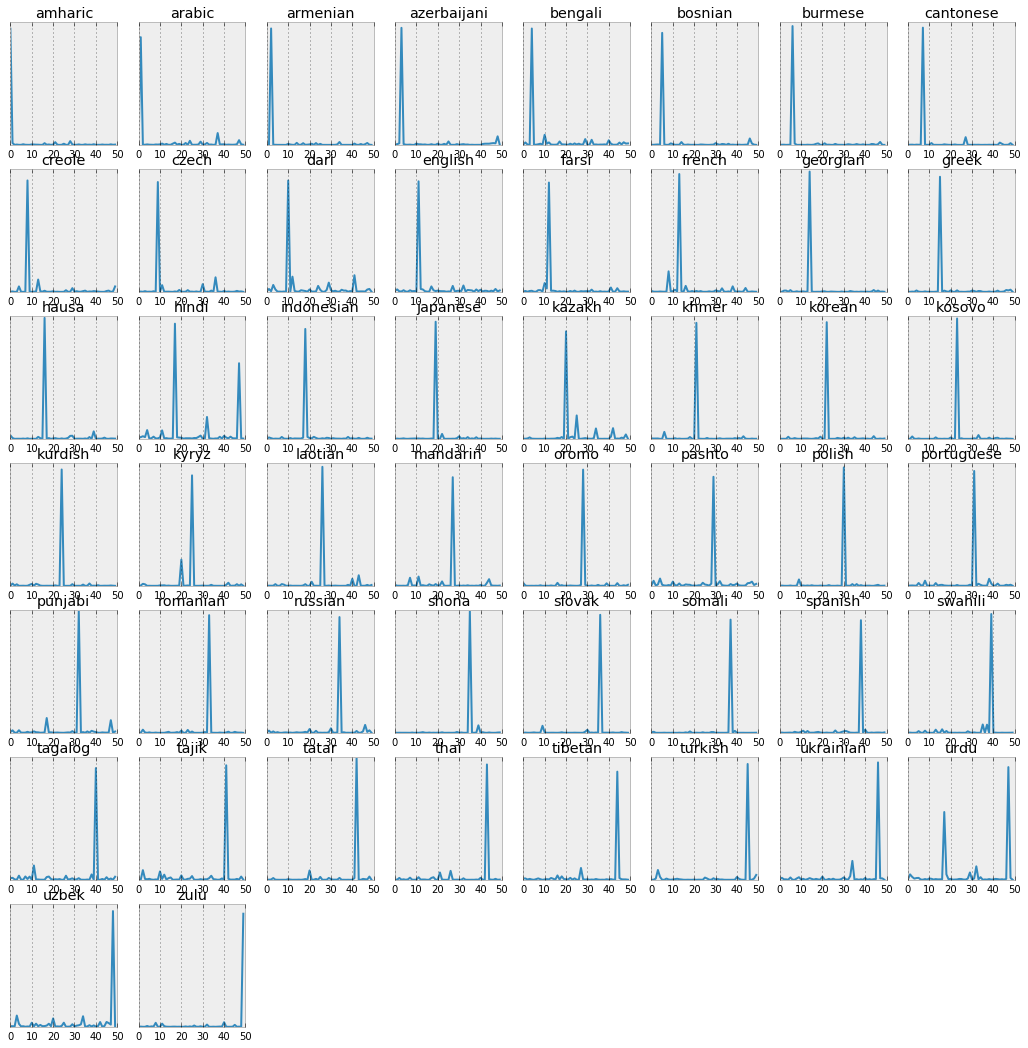

In [16]:
plt.figure(figsize=(18,18))
for i in range(50):
    plt.subplot(7,8,i+1)
    plt.plot(y_avg[i])
    plt.gca().get_yaxis().set_visible(False)
    plt.title(idx2lang[i])

## strongest pairs

For each language we can find the other language which has on average the highest probability. Note that the relations are not exactly symetric

In [17]:
pairs = []
for i in range(50):
    yp = y_avg[i].copy()
    yp[yp.argmax()] = 0
    pairs.append((idx2lang[i],idx2lang[yp.argmax()],yp.max()))
pairs.sort(key=lambda x: -x[2])

for lang, second_lang, score in pairs:
    print '%-15s  %-15s  %g'%(lang, second_lang, score)

hindi            urdu             0.277838
urdu             hindi            0.276757
kyryz            kazakh           0.171282
kazakh           kyryz            0.133747
french           creole           0.117313
ukrainian        russian          0.107967
czech            slovak           0.0952696
punjabi          hindi            0.0847553
tagalog          english          0.0820452
dari             tajik            0.0814773
creole           french           0.0807614
tibetan          mandarin         0.0775205
arabic           somali           0.0774684
laotian          thai             0.0692329
turkish          azerbaijani      0.0642177
tatar            kazakh           0.0612608
mandarin         english          0.0606959
thai             laotian          0.0586004
bengali          dari             0.0578049
farsi            dari             0.057663
cantonese        mandarin         0.0568332
azerbaijani      uzbek            0.0559496
tajik            armenian         0.055

## graph plot

finally it is possible to use the weights as weights for edges in a directed graph. The graph is visualized. The width of the edges in the graph are porportinal to the probability the relation received in the average prediction matrix (weight below 1/50 don't appear.)

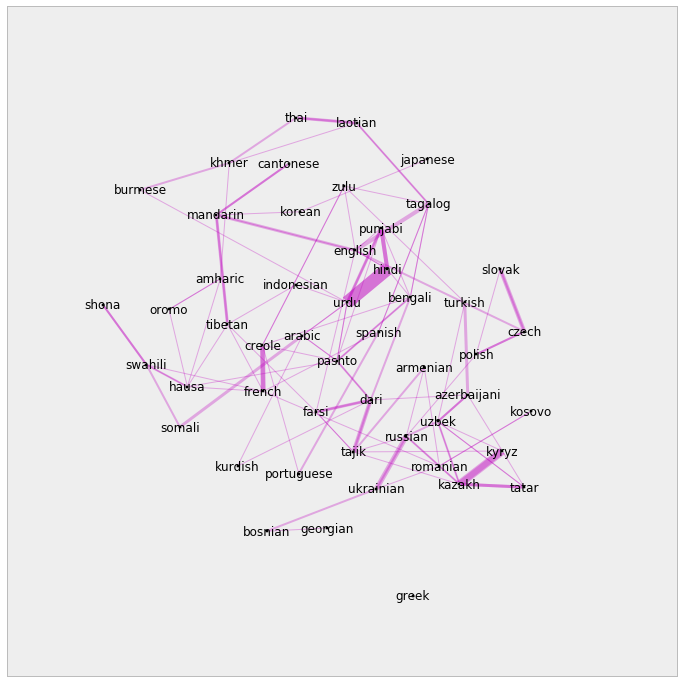

In [26]:
import networkx as nx
G = nx.DiGraph(y_avg)
G = nx.relabel_nodes(G,dict(enumerate(idx2lang)))

# try:
#     pos=nx.graphviz_layout(G,prog='dot')
# except:
pos=nx.spring_layout(G,iterations=100)

edgewidth=[]
for (u,v,d) in G.edges(data=True):
    edgewidth.append(int(50*G.get_edge_data(u,v)['weight']))

plt.figure(figsize=(12,12))
nx.draw_networkx_edges(G,pos,alpha=0.3,width=edgewidth, edge_color='m',arrows=False)
nx.draw_networkx_nodes(G,pos,node_size=12,node_color='k') # ,alpha=0.8)
nx.draw_networkx_labels(G,pos,fontsize=14)
plt.xticks([])
plt.yticks([])
plt.gca().grid(False);